In [139]:
from importlib import reload
import galsurvey
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt

reload(galsurvey)

<module 'galsurvey' from 'C:\\Users\\yanlo\\OneDrive - California Institute of Technology\\2019-Bispectrum-Neutrino\\Notebooks\\galsurvey.py'>

In [2]:
omega_m = 0.307494
omega_bh2 = 0.022300
omega_ch2 = 0.118800
omega_l = 1 - omega_m
h = np.sqrt((omega_bh2 + omega_ch2) / omega_m)
omega_b = omega_bh2/h**2
sf = 99.91 #from camb

In [3]:
cosmo_params = {
    'Omega_m': omega_m,
    'Omega_L': omega_l,
    'Omega_b': omega_b,
    'h': h,
    's_f': sf,
    'sigma8_0': 0.9
}

In [4]:
cosmo = galsurvey.cosmology(cosmo_params)

In [5]:
attrs = vars(cosmo)
print(', '.join("%s: %s" % item for item in attrs.items()))

Omega_m: 0.307494, Omega_L: 0.6925060000000001, Omega_b: 0.04859756343019135, h: 0.6773999868566161, s_f: 99.91, sigma8_0: 0.9, astropy_cosmology: FlatLambdaCDM(H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None), D0: 0.7825237557360316


In [6]:
cosmo.comoving_distance(1)

2302.4862192049272

In [7]:
cosmo.linear_growth_factor(0)

0.7825237557360316

In [8]:
ps_file='planck_camb_56106182_matterpower_z0.dat'
ps_nw_file='planck_camb_56106182_matterpower_smooth_z0.dat'
ps = galsurvey.ps_interpolation(ps_file, ps_nw_file)

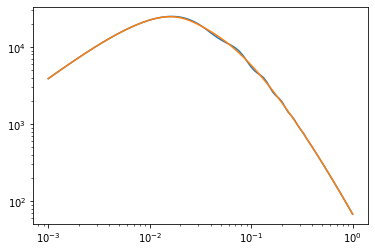

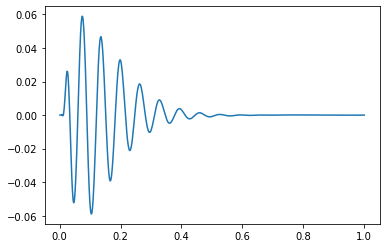

In [9]:
k=np.logspace(-3, 0, num=100)
p=ps.matter_power_spectrum(k)
pnw=ps.matter_power_spectrum_no_wiggle(k)
plt.loglog(k, p)
plt.loglog(k, pnw)
plt.show()

k=np.linspace(0.001, 1, num=1000)
o=ps.oscillation_part(k)
plt.plot(k, o)
plt.show()

In [117]:
survey_geo = {
    'f_sky': 0.5,
    'N_g': 1e7,
    'z_min': 0.1,
    'z_max': 2,
    'dz': 0.1
}
survey_params = {
    'Sigma_0': 16.6,
    'reconstruction_rate': 0.5,
    'b_0': 0.95,
    'survey_type': 'spectroscopic'
}

ig_full = ['RSD', 'damping', 'FOG', 'galactic_bias', 'reconstruction']
ig_none = []
ingredients = ig_none


sf_p18 = 97.288
dsf_p18 = 0.799344

priors = {
    'alpha_prior': {
        'mean': sf_p18/sf,
        'stdev': dsf_p18/sf
    },
    'beta_prior': {
        'mean': 1.0,
        'stdev': 1e100 # to be constrained
    }
}

priors_plk = {
    'alpha_prior': {
        'mean': sf_p18/sf,
        'stdev': dsf_p18/sf
    },
    'beta_prior': {
        'mean': 1.0,
        'stdev': 1e100 # to be constrained
    }
}

In [140]:
svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ingredients, priors)
svy.cosmo = cosmo
svy.ps = ps
#svy.get_ready()

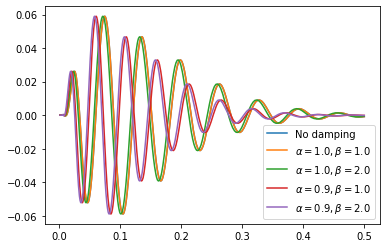

In [125]:
import itertools
k=np.linspace(0.001, 0.5, num=1000)
svy.alpha_prior['mean'] = 1
svy.beta_prior['mean'] = 1
o=svy.oscillation_part(k, damp=False)
plt.plot(k, o, label='No damping')

for [a, b] in list(itertools.product([1, 0.9], [1, 2])):
    svy.alpha_prior['mean'] = a
    svy.beta_prior['mean'] = b
    o=svy.oscillation_part(k)
    plt.plot(k, o, label=r'$\alpha=%.1f, \beta=%.1f$'%(a, b))
plt.legend()
plt.show()

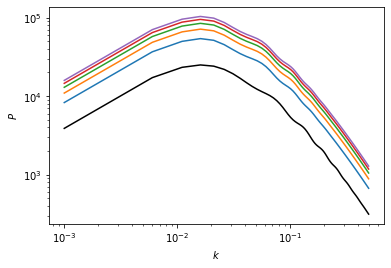

In [17]:
klst = np.linspace(0.001, 0.5, num=100) 
zlst = [0, 0.5, 1, 1.5, 2]
plt.loglog(klst, ps.matter_power_spectrum(klst), 'k')
for z in zlst:
    plst = svy.power_spectrum(klst, 1, z)
    plt.loglog(klst, plst)
plt.xlabel(r'$k$')
plt.ylabel(r'$P$')
plt.show()

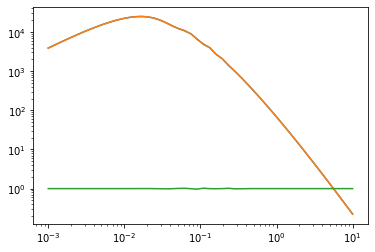

In [59]:
svy_m = galsurvey.survey(cosmo, ps, survey_geo, survey_params, [], priors)
k = np.logspace(-3, 1)
p = ps.matter_power_spectrum(k)
p_m = svy_m.power_spectrum(k)
plt.loglog(k, p)
plt.loglog(k, p_m)
plt.loglog(k, p_m/p)
plt.show()

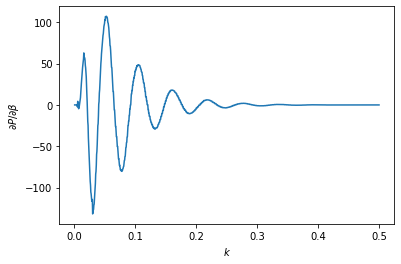

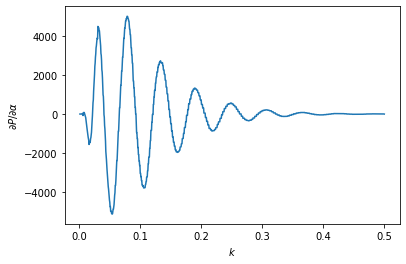

In [19]:
klst = np.linspace(0.001, 0.5, num=1000) 
vlst = svy_m.power_spectrum_derivative(klst)
plt.plot(klst, vlst[1])
plt.xlabel(r'$k$')
plt.ylabel(r'$\partial P/ \partial \beta$')
plt.show()

plt.plot(klst, vlst[0])
plt.xlabel(r'$k$')
plt.ylabel(r'$\partial P/ \partial \alpha$')
plt.show()

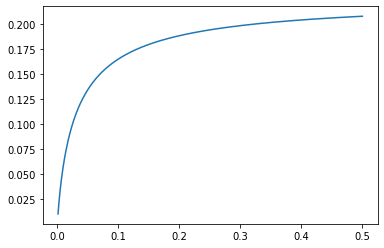

In [20]:
plt.plot(klst, galsurvey.f_phase(klst))
plt.show()

In [21]:
region_ps_0={
    'k_min': 0.01,
    'k_max': 0.5,
    'mu_min': -1.0,
    'mu_max': 1.0
}
regions_ps = [region_ps_0]

#svy.fisher_matrix_ps(regions_ps)

In [23]:
svy.fisher_matrix_ps(regions_ps, div_k=100, div_mu=10)

array([[ 1.37355678e+05, -1.43328066e+03],
       [-1.43328066e+03,  1.85168569e+01]])

In [115]:
region_bs_0={
    'k1_min': 0.01,
    'k1_max': 0.5,
    'k2_min': 0.01,
    'k2_max': 0.5,
    'k3_min': 0.01,
    'k3_max': 0.5,
}
regions_bs = [region_bs_0]

In [141]:
svy.fisher_matrix_bs(regions_bs, div_k1=20, div_k2=20, div_k3=20)

[[ 3.85478620e+08 -4.27558235e+06]
 [-4.27558235e+06  5.19597750e+04]]
[[ 8.51892306e+08 -9.44886568e+06]
 [-9.44886568e+06  1.14829021e+05]]
[[ 1.34265490e+09 -1.48922178e+07]
 [-1.48922178e+07  1.80980326e+05]]
[[ 1.78720524e+09 -1.98230013e+07]
 [-1.98230013e+07  2.40902549e+05]]
[[ 2.15210038e+09 -2.38702794e+07]
 [-2.38702794e+07  2.90087817e+05]]
[[ 2.42756045e+09 -2.69255779e+07]
 [-2.69255779e+07  3.27217875e+05]]
[[ 2.61735015e+09 -2.90306531e+07]
 [-2.90306531e+07  3.52800175e+05]]
[[ 2.73191335e+09 -3.03013445e+07]
 [-3.03013445e+07  3.68242479e+05]]
[[ 2.78410754e+09 -3.08802627e+07]
 [-3.08802627e+07  3.75277885e+05]]
[[ 2.78678518e+09 -3.09099620e+07]
 [-3.09099620e+07  3.75638812e+05]]
[[ 2.75157927e+09 -3.05194714e+07]
 [-3.05194714e+07  3.70893305e+05]]
[[ 2.68841812e+09 -2.98189120e+07]
 [-2.98189120e+07  3.62379633e+05]]
[[ 2.60544873e+09 -2.88986471e+07]
 [-2.88986471e+07  3.51195949e+05]]
[[ 2.50916694e+09 -2.78307261e+07]
 [-2.78307261e+07  3.38217849e+05]]
[[ 2.4

array([[ 4.13509333e+10, -4.58648662e+08],
       [-4.58648662e+08,  5.57380945e+06]])

In [145]:
0.5/(np.pi/svy.cosmo.s_f)

15.901170364311264

In [24]:
def fib(num):
    if num < 2:
        return num
    else:
        return fib(num-1) + fib(num-2)
%timeit fib(20)

1.71 ms ± 66.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
import functools

@functools.lru_cache(maxsize=None)
def fib(num):
    if num < 2:
        return num
    else:
        return fib(num-1) + fib(num-2)
    
%timeit fib(21)

57 ns ± 1.61 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [60]:
svy.oscillation_part(1)

array(3.73254697e-05)

In [28]:
zlst = np.linspace(0.2, 4, num=39)
Nglst = [ 1e6, 1e7, 1e8, 1e100]
slst = np.zeros((len(Nglst), len(zlst)))
div_k, div_mu = 10, 10
#fisherlst = np.zeros((len(Nglst), len(zlst), 2, 2))
for j in range(len(zlst)):
    z = zlst[j]
    print(z, end=' ')
    survey_geo['z_max']=z
    for i in range(len(Nglst)):
        survey_geo['N_g']=Nglst[i]
        svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ingredients, priors)
        #svy.cosmo = cosmo
        #svy.ps = ps
        #svy.get_ready()
        fisher = svy.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)
        slst[i,j] = svy.beta_stdev
        del svy

0.2 0.3 0.4 0.5 0.6 0.7 0.8 

KeyboardInterrupt: 

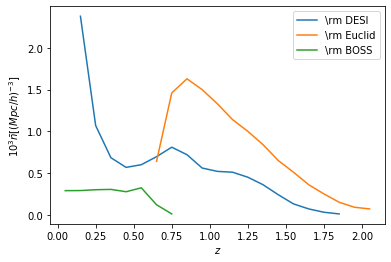

In [29]:
ndesi = np.loadtxt('desi-density.txt')
neuclid = np.loadtxt('euclid-density.txt')
nboss = np.loadtxt('boss-density.txt')
ndesi[:,1]/=1e3
neuclid[:,1]/=1e3
nboss[:,1]/=1e3
plt.plot(ndesi[:,0], ndesi[:,1]*1e3, label = r'\rm DESI')
plt.plot(neuclid[:,0], neuclid[:,1]*1e3, label = r'\rm Euclid')
plt.plot(nboss[:,0], nboss[:,1]*1e3, label = r'\rm BOSS')
plt.xlabel(r'$z$')
plt.ylabel(r'$10^3\bar{n}[(Mpc/h)^{-3}]$')
plt.legend()
plt.show()

In [102]:
sky_deg = 4*np.pi*(180/np.pi)**2
desi_geo = {
    'f_sky': 14000/sky_deg,
    'ng_z_list': ndesi,
    'dz': 0.1
}
euclid_geo = {
    'f_sky': 15000/sky_deg,
    'ng_z_list': neuclid,
    'dz': 0.1
}
boss_geo = {
    'f_sky': 10000/sky_deg,
    'ng_z_list': nboss,
    'dz': 0.1
}
desi = galsurvey.survey(cosmo, ps, desi_geo, survey_params, ingredients, priors_plk)
#desi.cosmo = cosmo
#desi.ps = ps
#desi.get_ready()
fisher_desi = desi.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)

euclid = galsurvey.survey(cosmo, ps, euclid_geo, survey_params, ingredients, priors)
#euclid.cosmo = cosmo
#euclid.ps = ps
#euclid.get_ready()
fisher_euclid = euclid.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)

boss = galsurvey.survey(cosmo, ps, boss_geo, survey_params, ingredients, priors)
#boss.cosmo = cosmo
#boss.ps = ps
#boss.get_ready()
fisher_boss = boss.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)

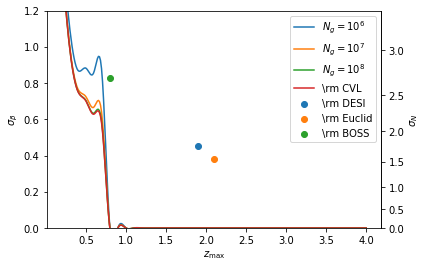

In [31]:
from scipy.interpolate import make_interp_spline, BSpline



def b2n(x):
    return 4.4/1.45 - 4.4* (-x + 1)/(2.45 - (-x + 1))
def n2b(y):
    t = 4.4/1.45 -y
    return 1 - 2.45*t/(t+4.4)
    
    
fig, ax = plt.subplots()
ax_r = ax.secondary_yaxis("right", functions=(b2n, n2b))

labels = [ r'$N_g=10^6$', r'$N_g=10^7$', r'$N_g=10^8$', r'\rm CVL']
for i in range(len(slst)):
    xnew = np.linspace(zlst.min(), zlst.max(), 300) 
    spl = make_interp_spline(zlst, slst[i], k=3)
    ynew = spl(xnew)
    ax.plot(xnew, ynew, label=labels[i])
    #ax.plot(zlst, slst[i], c='k')

ax.scatter(desi.z_max, desi.beta_stdev, label=r'\rm DESI')
ax.scatter(euclid.z_max, euclid.beta_stdev, label=r'\rm Euclid')
ax.scatter(boss.z_max, boss.beta_stdev, label=r'\rm BOSS')
ax.legend()
ax.set_xlabel(r'$z_{\rm max}$')
ax.set_ylabel(r'$\sigma_\beta$')
ax_r.set_ylabel(r'$\sigma_N$')
ax.set_ylim(0,1.2)
plt.show()

In [116]:
%timeit desi.integrand_ps(0.4, 0.4, 0.4, 1, 1, simplify=False)
%timeit desi.integrand_ps(0.4, 0.4, 0.4, 1, 1, simplify=True)
print(desi.integrand_ps(0.2, 0.4, 0.4, 0, 0, simplify=False))
print(desi.integrand_ps(0.2, 0.4, 0.4, 0, 0, simplify=True))

347 ns ± 4.14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
346 ns ± 3.48 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
0.0010032495134611843
0.0009948736519798569


In [117]:
%timeit desi.naive_integration_ps(args=(0.4, 1, 1))

58.1 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [51]:
from numba import jit

x = np.arange(100).reshape(10, 10)

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

In [52]:
%timeit go_fast(x)

The slowest run took 12.80 times longer than the fastest. This could mean that an intermediate result is being cached.
3.71 µs ± 4.16 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


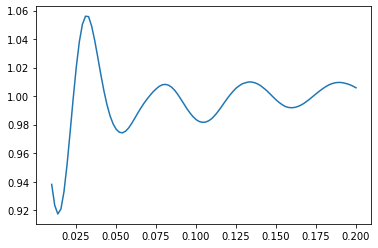

In [62]:
klst = np.linspace(0.01, 0.2, num=100)
rlst = desi.R_bi(kargs=(klst, desi.pisf, 0))
plt.plot(klst, rlst)

In [68]:
svy=desi
def get_Amat(svy):
    tiny = 1e-4
    deltalst = y = np.linspace(tiny*svy.pisf, (4-tiny)*svy.pisf, num=20)
    thetalst = x = np.linspace(np.pi*tiny, np.pi*(1-tiny), num=20)
    dmat, tmat = np.meshgrid(deltalst, thetalst)
    #4extent = np.min(x), np.max(x), np.min(y), np.max(y)
    Amat = np.zeros(dmat.shape)
    print(svy.alpha_prior, svy.beta_prior)
    for i in range(len(deltalst)):
        for j in range(len(thetalst)):
            Amat[i,j] = svy.A_bi(dmat[i,j], tmat[i,j], k1_min=0.01, div_k1=10000)
    return Amat

Amat = get_Amat(svy)

{'mean': 0.9737563807426683, 'stdev': 0.008000640576518867} {'mean': 1.0, 'stdev': 1e+100}


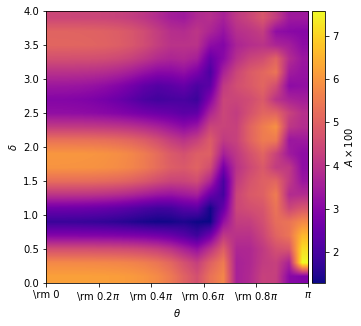

In [69]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter, MultipleLocator
f = plt.figure(figsize=(5, 5))
ax = f.add_subplot(111)
cmap = plt.get_cmap('plasma')
extent = 0, np.pi, 0, 4
im = ax.imshow(Amat.T*100, cmap=cmap, interpolation='bilinear', extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label(r'$A\times 100$')

ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val, pos: r'\rm 0' if val==0 else r'\rm {:.3g}$\pi$'.format(val/np.pi) if np.abs(val)!=np.pi else r'$-\pi$' if val==-np.pi else r'$\pi$'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\delta$')
plt.savefig('bi_inter.pdf', bbox_inches='tight')
plt.show()

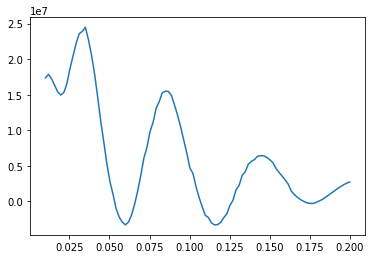

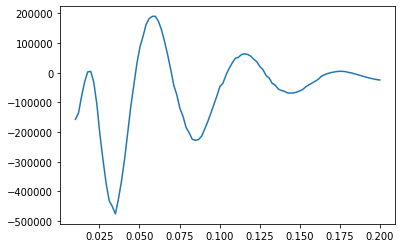

In [111]:
klst = np.linspace(0.01, 0.2, num=100)
rlst=[]
for k in klst:
    rlst.append( desi.bispectrum_derivative(kargs=(k, 0.2, 0.2)))
rlst=np.array(rlst)
plt.plot(klst, rlst[:,0])
plt.show()
plt.plot(klst, rlst[:,1])
plt.show()

array([[ 1,  2,  3,  3],
       [ 4,  8, 10, 14]])